In [23]:
from os import listdir
from os.path import isfile, join
from matplotlib import image
from matplotlib import pyplot
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [24]:
mypath = "/Users/apple/Desktop/eeglab14_1_2b/Granger Casuality/img/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.sort()

In [25]:
X = []
for i in range(len(onlyfiles)):
    data = Image.open(mypath + onlyfiles[i])
    arr = np.array(data)
    X.append(arr)
print(len(X))
print(X[1].shape)

1280
(32, 32, 4)


In [26]:

df = pd.read_csv('/Users/apple/Desktop/eeglab14_1_2b/participant_ratings.csv',
                sep=r'\s*,\s*',engine = 'python', na_values = '?')
df.dropna()
Y_chart = pd.get_dummies(df, drop_first=True)
Y = Y_chart['Liking'].tolist()
print(len(Y))

1280


In [27]:
for i in range(len(Y)):
    if Y[i] < 5:
        Y[i] = 0
    else:
        Y[i] = 1
print(len(Y))

1280


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=(40/len(Y)))
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
print(X_train.shape)
print(y_train.shape)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print(X_test.shape)
print(y_test.shape)

(1240, 32, 32, 4)
(1240,)
(40, 32, 32, 4)
(40,)


In [29]:
print('Image dataset have shape =', X_train.shape)
print('Image dataset has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train.min(),
                        X_train.mean(), X_train.std(), X_train.max()))
print('')
print('Train label has shape =', y_train.shape)
print('Training label has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train.min(),
                        y_train.mean(), y_train.std(), y_train.max()))

Image dataset have shape = (1240, 32, 32, 4)
Image dataset has min/mean/std/max = 1.00/139.58/79.39/255.00

Train label has shape = (1240,)
Training label has min/mean/std/max = 0.00/0.67/0.47/1.00


In [30]:
def normalize_data(data): 
    data = data / data.max()
    return data

X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
print('Image dataset have shape =', X_train.shape)
print('Image dataset has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train.min(),
                        X_train.mean(), X_train.std(), X_train.max()))
print('')
print('Train label has shape =', y_train.shape)
print('Training label has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train.min(),
                        y_train.mean(), y_train.std(), y_train.max()))

Image dataset have shape = (1240, 32, 32, 4)
Image dataset has min/mean/std/max = 0.00/0.55/0.31/1.00

Train label has shape = (1240,)
Training label has min/mean/std/max = 0.00/0.67/0.47/1.00


In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [32]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.from_numpy(y_train)
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test])
tensor_y_test = torch.from_numpy(y_test)

In [33]:
trainset = utils.TensorDataset(tensor_x,tensor_y)
trainloader = utils.DataLoader(trainset,  batch_size= 40)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test)
testloader = utils.DataLoader(testset,  batch_size=40)

In [34]:
device = torch.device("cpu")
classes = ('Positive', 'Negative')
print(device)

cpu


In [35]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([40, 32, 32, 4])
torch.Size([40, 4, 32, 32])


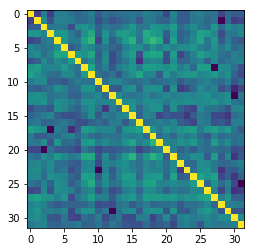

In [36]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images = images.permute(0, 3, 1, 2)
print(images.size())
%matplotlib inline
rows = 1
columns = 1
fig=plt.figure()
for i in range(1):
    fig.add_subplot(rows, columns, i+1)
    img = images[i]
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()

num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 3)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv2_bn = nn.BatchNorm2d(10)
        
        #spatial transformer localization
        self.localization = nn.Sequential(
            nn.Conv2d(4, 10, 3, padding = 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            nn.Conv2d(10, 20, 3, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(True)
            
        ) 
        #add an regressor
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(16*6*6, 96),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(96, 6),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(6, num_classes),
        )
   
    def forward(self, x):
        #x = self.stn(x)
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        #x = F.dropout2d(x, p=0.5)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.flat(x))
        x = self.classifier(x)
        return x
    
    def flat(self, x):
        size = x.size()[1:]
        num = 1
        for s in size:
            num *= s
        return num
    
net = Net()
net.to(device)

In [37]:
num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 10, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(10)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(20*8*8, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 8 * 8)
        x = self.classifier(x)
        return x
    
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=1280, out_features=100, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
#opt = torch.optim.Adam(net.parameters(), lr= 0.001)
#opt = torch.optim.Adamax(net.parameters(), lr=0.01)
#opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
opt = torch.optim.Adagrad(net.parameters(), lr=0.01)
#avg_losses = [] 
epochs = 500
print_freq = 20
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        if i % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    19] avg mini-batch loss: 0.939
[epoch: 1, i:    19] avg mini-batch loss: 0.243
[epoch: 2, i:    19] avg mini-batch loss: 0.183
[epoch: 3, i:    19] avg mini-batch loss: 0.157
[epoch: 4, i:    19] avg mini-batch loss: 0.140
[epoch: 5, i:    19] avg mini-batch loss: 0.125
[epoch: 6, i:    19] avg mini-batch loss: 0.114
[epoch: 7, i:    19] avg mini-batch loss: 0.105
[epoch: 8, i:    19] avg mini-batch loss: 0.098
[epoch: 9, i:    19] avg mini-batch loss: 0.091
[epoch: 10, i:    19] avg mini-batch loss: 0.085
[epoch: 11, i:    19] avg mini-batch loss: 0.080
[epoch: 12, i:    19] avg mini-batch loss: 0.075
[epoch: 13, i:    19] avg mini-batch loss: 0.071
[epoch: 14, i:    19] avg mini-batch loss: 0.066
[epoch: 15, i:    19] avg mini-batch loss: 0.063
[epoch: 16, i:    19] avg mini-batch loss: 0.059
[epoch: 17, i:    19] avg mini-batch loss: 0.056
[epoch: 18, i:    19] avg mini-batch loss: 0.053
[epoch: 19, i:    19] avg mini-batch loss: 0.051
[epoch: 20, i:    19] avg mini

[epoch: 167, i:    19] avg mini-batch loss: 0.002
[epoch: 168, i:    19] avg mini-batch loss: 0.002
[epoch: 169, i:    19] avg mini-batch loss: 0.002
[epoch: 170, i:    19] avg mini-batch loss: 0.002
[epoch: 171, i:    19] avg mini-batch loss: 0.002
[epoch: 172, i:    19] avg mini-batch loss: 0.002
[epoch: 173, i:    19] avg mini-batch loss: 0.002
[epoch: 174, i:    19] avg mini-batch loss: 0.002
[epoch: 175, i:    19] avg mini-batch loss: 0.002
[epoch: 176, i:    19] avg mini-batch loss: 0.002
[epoch: 177, i:    19] avg mini-batch loss: 0.002
[epoch: 178, i:    19] avg mini-batch loss: 0.002
[epoch: 179, i:    19] avg mini-batch loss: 0.002
[epoch: 180, i:    19] avg mini-batch loss: 0.002
[epoch: 181, i:    19] avg mini-batch loss: 0.002
[epoch: 182, i:    19] avg mini-batch loss: 0.002
[epoch: 183, i:    19] avg mini-batch loss: 0.002
[epoch: 184, i:    19] avg mini-batch loss: 0.002
[epoch: 185, i:    19] avg mini-batch loss: 0.002
[epoch: 186, i:    19] avg mini-batch loss: 0.002


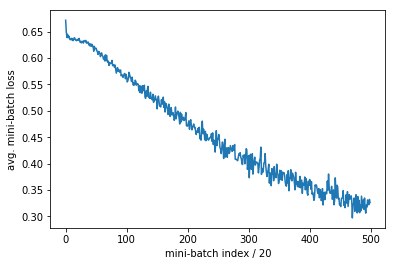

In [39]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [40]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        one = torch.tensor(1, dtype=torch.float, device=device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

40
Accuracy of the network on the 40 test images: 57 %
Accuracy of Positive : 15 %
Accuracy of Negative : 77 %


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [41]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 1240 training images: %d %%' % (100 * correct / total))
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        one = torch.tensor(1, dtype=torch.float, device=device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

1240
Accuracy of the network on the 1240 training images: 95 %


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of Positive : 90 %
Accuracy of Negative : 98 %
